In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [10]:
df_atvi = pd.read_csv("atvi_weekly_return_volatility.csv")
df_spy = pd.read_csv("spy_weekly_return_volatility.csv")

In [13]:
def get_best_n_d(df, stocks):
    n = np.array([1, 3, 5, 7, 9])
    d = np.array([1, 2, 3, 4, 5])
    acc = []
    max_acc = 0
    for i in range(n.shape[0]):
        for j in range(d.shape[0]):
            df_train = df[df["Year"] == 2021]
            X_train = df_train[["mean_return", "volatility"]]
            y_train = df_train[["Label"]].values.flatten()
            le = LabelEncoder()
            y_train = le.fit_transform(y_train)
            df_test = df[df["Year"] == 2022]
            X_test = df_test[["mean_return", "volatility"]]
            y_test = le.fit_transform(df_test[["Label"]].values.flatten())
            rf_clf = RandomForestClassifier(n_estimators=n[i], max_depth=d[j])
            rf_clf.fit(X_train, y_train)
            y_pred = rf_clf.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            acc.append(100*accuracy)
            if accuracy > max_acc:
                max_acc = accuracy
                n_best = n[i]
                d_best = d[j]
                rf_model_best = rf_clf
    
    steps = range(0, 30, 5)
    plt.figure(figsize=(15, 10))
    for i in range(len(steps)-1):
        plt.plot(d, acc[steps[i]:steps[i+1]])
    plt.title(f"Accuracies for different depths and different estimators for {stocks}")
    plt.xlabel("Depth")
    plt.ylabel("Accuracies (in %)")
    plt.legend(["N = 1", "N = 3", "N = 5", "N = 7", "N = 9"])
    plt.show()
    
    print(f"Best N -> {n_best}")
    print(f"Best D -> {d_best}")
    print(f"Best Accuracy -> {100*max_acc} %")
    return n_best, d_best

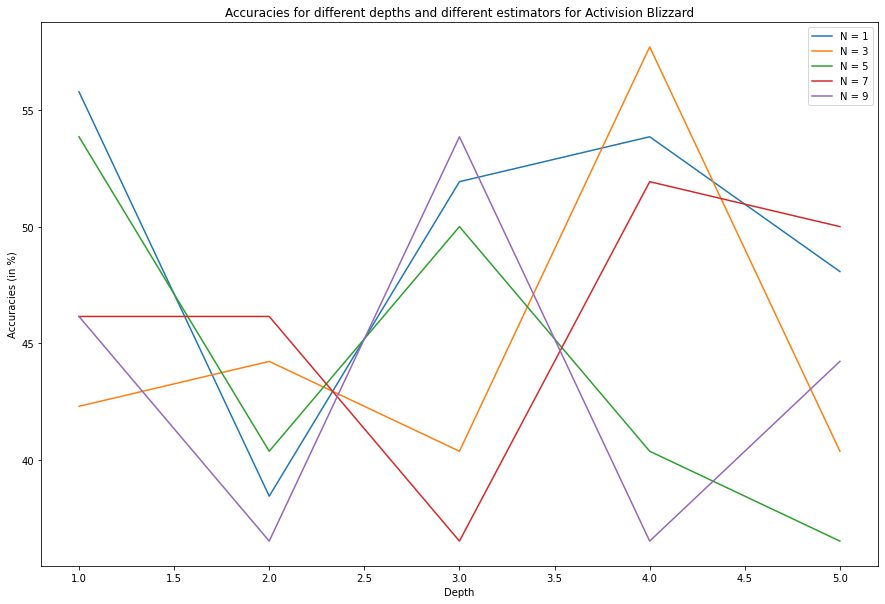

Best N -> 3
Best D -> 4
Best Accuracy -> 57.692307692307686 %


In [31]:
n_best_atvi, d_best_atvi = get_best_n_d(df_atvi, "Activision Blizzard")

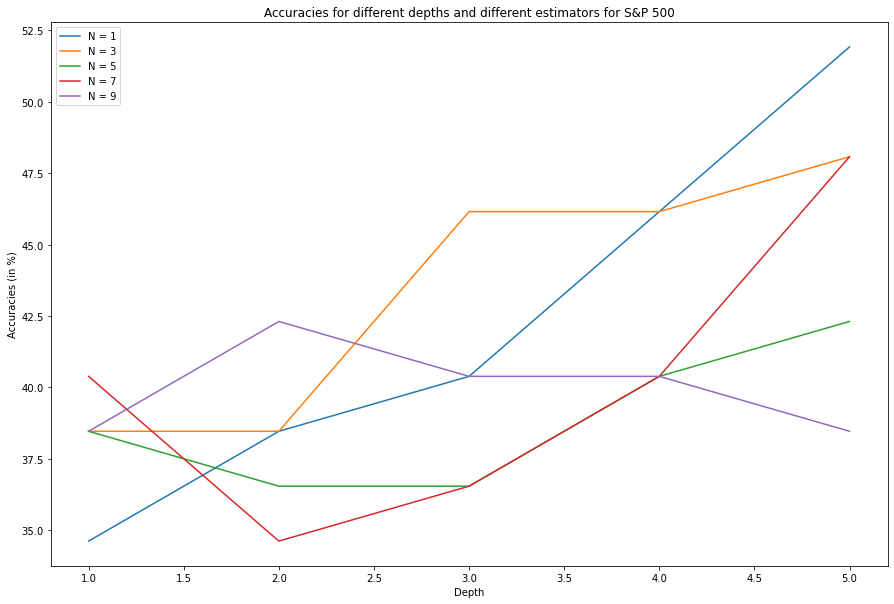

Best N -> 1
Best D -> 5
Best Accuracy -> 51.92307692307693 %


In [32]:
n_best_spy, d_best_spy = get_best_n_d(df_spy, "S&P 500")

In [36]:
def metrics_bnh_vs_clf(df, n_best, d_best, stocks):
    df_train = df[df["Year"] == 2021]
    X_train = df_train[["mean_return", "volatility"]]
    y_train = df_train[["Label"]].values.flatten()
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    df_test = df[df["Year"] == 2022]
    X_test = df_test[["mean_return", "volatility"]]
    y_test = le.fit_transform(df_test[["Label"]].values.flatten())
    rf_clf = RandomForestClassifier(n_estimators = n_best, max_depth = d_best)
    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(conf_matrix, display_labels=["Green", "Red"]).plot()
    tp = conf_matrix[0][0]
    tn = conf_matrix[1][1]
    fp = conf_matrix[1][0]
    fn = conf_matrix[0][1]
    tpr = tp/(tp + fn)
    tnr = tn/(tn + fp)
    acc = accuracy_score(y_test, y_pred)
    print(f"\nAccuracy for Year 2 -> {round(100*acc, 2)} %")
    print(f"Recall for Year 2 -> {round(100*tpr, 2)} %")
    print(f"Specificity for Year 2 -> {round(100*tnr, 2)} %")
    
    df_yr2 = df[df["Year"] == 2022]
    ret_yr2 = df_yr2[["mean_return"]].values.flatten()
    i1, i2 = 100, 100
    bnh, rf = [], []
    for i in range(y_pred.shape[0]):
        if y_pred[i] == 0:
            i2 = i2*(1+ret_yr2[i]/100)
        i1 = i1*(1+ret_yr2[i]/100)
        bnh.append(i1)
        rf.append(i2)
    
    plt.figure(figsize=(15, 10))
    plt.plot(bnh)
    plt.title(f"BnH Strategy for {stocks} for year 2")
    plt.ylabel("Returns")
    plt.xlabel("Weeks")
    plt.show()
    
    plt.figure(figsize=(15, 10))
    plt.plot(rf)
    plt.title(f"Classifier Strategy for {stocks} for year 2")
    plt.ylabel("Returns")
    plt.xlabel("Weeks")
    plt.show()
    
    print(f"Final Amount for BnH -> $ {round(i1, 2)}")
    print(f"Final Amount by trading according to labels -> $ {round(i2, 2)}")


Accuracy for Year 2 -> 57.69 %
Recall for Year 2 -> 42.86 %
Specificity for Year 2 -> 67.74 %


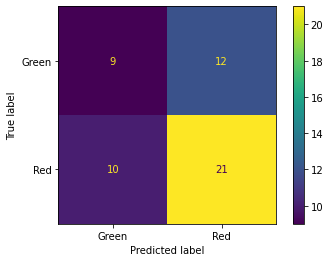

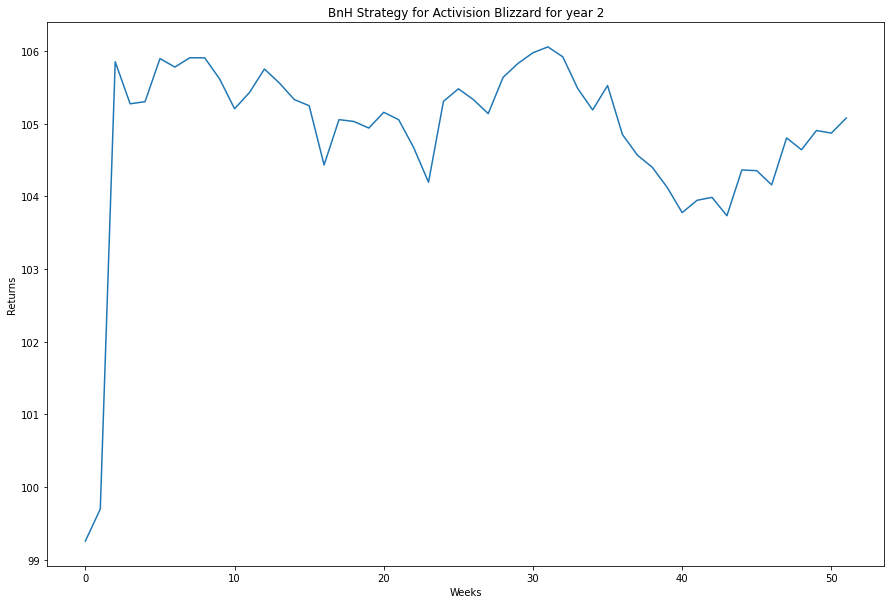

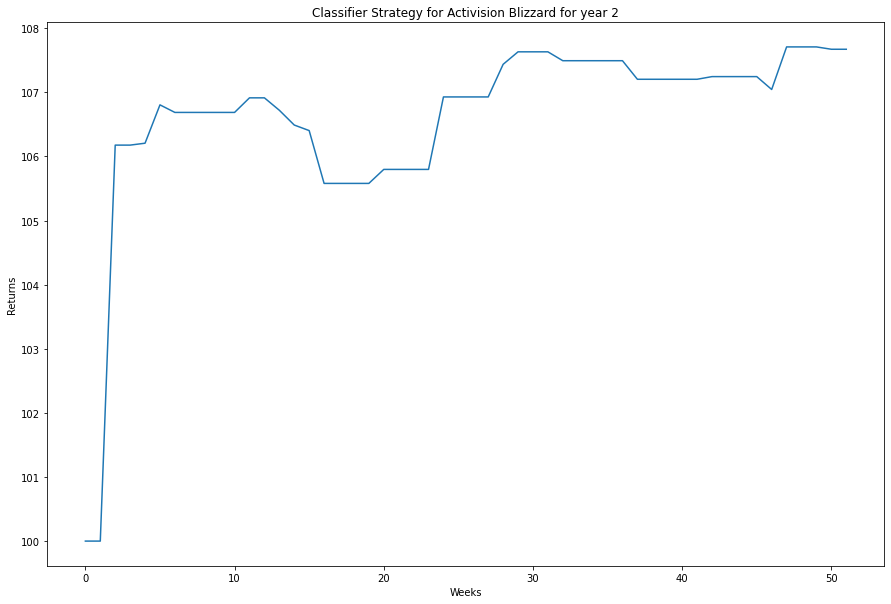

Final Amount for BnH -> $ 105.08
Final Amount by trading according to labels -> $ 107.67


In [37]:
metrics_bnh_vs_clf(df_atvi, n_best_atvi, d_best_atvi, "Activision Blizzard")


Accuracy for Year 2 -> 44.23 %
Recall for Year 2 -> 61.11 %
Specificity for Year 2 -> 35.29 %


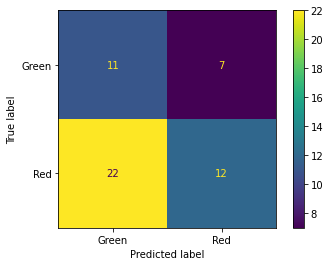

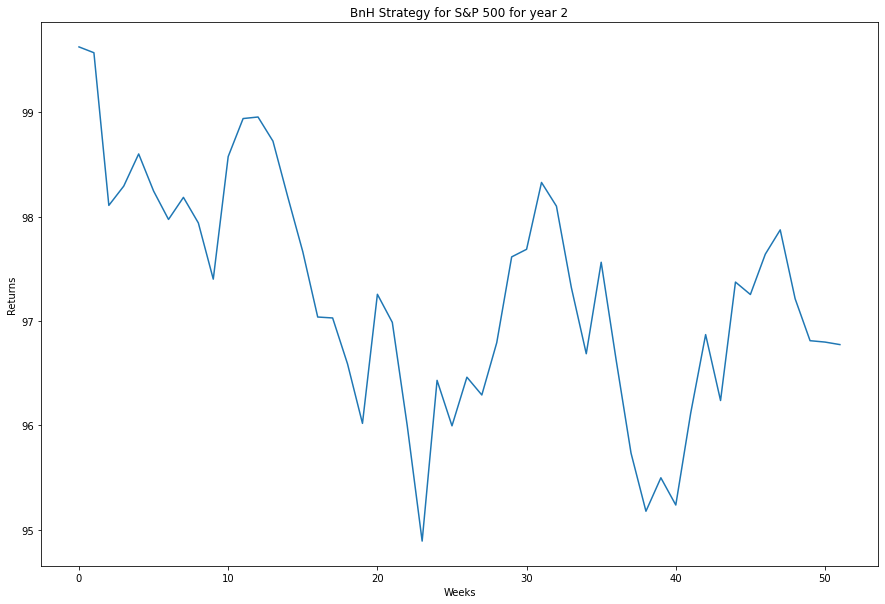

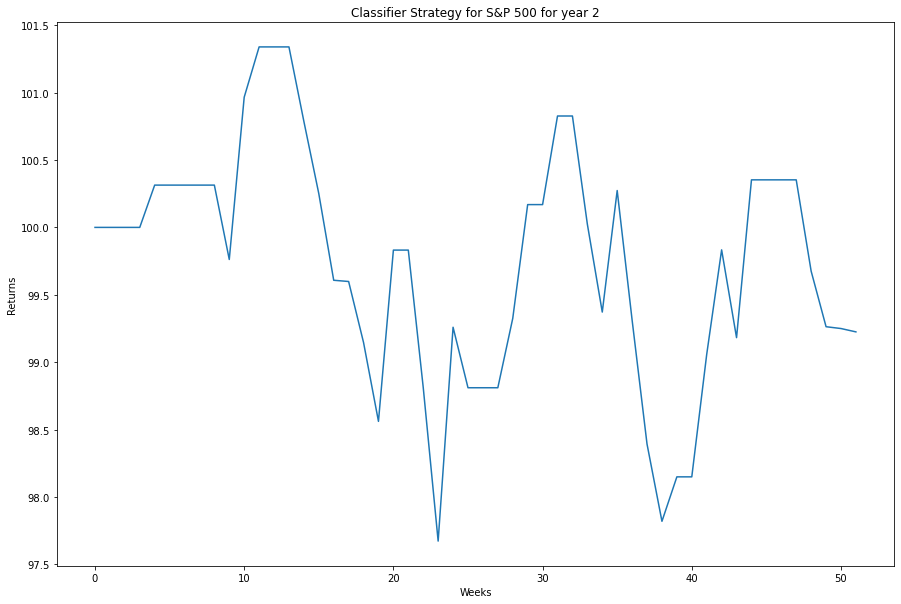

Final Amount for BnH -> $ 96.77
Final Amount by trading according to labels -> $ 99.23


In [39]:
metrics_bnh_vs_clf(df_spy, n_best_spy, d_best_spy, "S&P 500")